# Detection of Toxic Comments

Kaggle competition: [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

In [8]:
seed = 333

## Import

In [9]:
import csv
from datetime import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, LSTM, GRU, Activation,GlobalMaxPool1D,Bidirectional
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

## Load Embeddings

In [10]:
def read_embeddings(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [11]:
word_to_index, index_to_word, word_to_vec = read_embeddings('./glove/glove.twitter.27B.25d.txt')
word_to_vec["0.065581"] = [ 0.39605,  -0.96669,   0.23706,  -0.41379,  -0.97006,   0.16601,  -1.292,
 -0.58989,   0.11632,  -1.365,    -0.27939,  -0.57222,  -0.97108,  -0.56319,
 -0.015263, -0.70465,  -0.13867 ,  1.0702 ,  -0.25557  , 0.25122,  -0.87755,
  0.70999 ,  0.9118 ,  -0.30077, 0 ]


## Load Data

In [12]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
cache_english_stopwords=stopwords.words('english')

replacements = [
    ('f u c k', 'fuck'),
    ('f uck', 'fuck'),
    ('fuckyou', 'fuck you'),
    ('fuckmother', 'fuck mother'),
    ('WTF', 'what the fuck'),
    ('OMFG', 'oh my fucking god'),
    ('RTFM', 'read the fucking manual'),
    ('ASAFP', 'as soon as fucking possible'),
    ('FYVM',  'fuck you very much'),
    ('whatever TF', 'whatever the fuck')
]

bad_words = [
    'fuck',
    'motherfucker',
    'fucker',
    'idiot'
]

def data_clean(message):
    for a,b in replacements:
        message = message.replace(a, b)
    
    temp_tw_list = word_tokenize(message)
    # Remove stopwords
    list_no_stopwords=[i for i in temp_tw_list if i.lower() not in     cache_english_stopwords]
    # Remove hyperlinks
    list_no_hyperlinks=[re.sub(r'https?:\/\/.*\/\w*','',i) for i in list_no_stopwords]
    # Remove hashtags
    list_no_hashtags=[re.sub(r'#', '', i) for i in list_no_hyperlinks]
    #Remove numbers
    list_no_numbers = [re.sub(r'$\d+\W+|\b\d+\b|\W+\d+$','', i) for i in list_no_hashtags]
   # Remove Punctuation and split 's, 't, 've with a space for filter
    list_no_punctuation=[re.sub(r'['+string.punctuation+']+', ' ', i) for i in list_no_numbers]
    # Remove multiple whitespace
    new_sent = ' '.join(list_no_punctuation)
    # Remove any words with 2 or fewer letters
    filtered_list = word_tokenize(new_sent)
    list_filtered = [re.sub(r'^\w\w?$', '', i) for i in filtered_list]
    filtered_sent =' '.join(list_filtered)
    clean_sent=re.sub(r'\s\s+', ' ', filtered_sent)
    #Remove any whitespace at the front of the sentence
    clean_sent=clean_sent.lstrip(' ')
    # remove the articles
    clean_sent = re.sub('(\s+)(a|an|and|the)(\s+)', ' ', clean_sent)

    return clean_sent.lower()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mazhurin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mazhurin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
import re
from string import digits
def read_comments(filename = ''):
    comments = []
    labels = []
    ids = []
    remove_punctuation = str.maketrans('', '', string.punctuation)
    remove_digits = str.maketrans('', '', digits)

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        header = True
        progress = 0
        for row in csvReader:

            if progress % 10000 == 0:
                print ('Line', progress)
            progress += 1
            
            if header:
                header = False
                continue
            ids.append(row[0])
            #filtered_words = [word for word in s.split() if word not in stopwords.words('english')]
            filtered_words = data_clean(row[1]).split()
            words = []
            for w in filtered_words:
                if w in word_to_vec:
                    words.append(w)
                else:
                    for badword in bad_words:
                        if badword in w:
                            words.append(badword)
                            break

            comments.append(words)          
            if len(row) > 2:
                classes = []
                for i in range(2,8):
                    classes.append(row[i])
                labels.append(classes)

    ids = np.asarray(ids)
    X = np.asarray(comments)
    Y = np.asarray(labels, dtype=int)

    return ids, X, Y

In [ ]:
id_train, X_train, Y_train = read_comments('./data/train.csv')
id_test, X_test, _ = read_comments('./data/test.csv')
labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

max_comment = 0
for i in range(X_train.shape[0]):                               
    l = len(X_train[i])
    if max_comment < l:
        max_comment = l
for i in range(X_test.shape[0]):                               
    l = len(X_test[i])
    if max_comment < l:
        max_comment = l
num_classes = len(labels)
print ('Max word count =', max_comment)

Line 0
Line 10000
Line 20000
Line 30000
Line 40000
Line 50000
Line 60000
Line 70000
Line 80000
Line 90000


In [ ]:
max_comment = 200

## Split Data

In [ ]:
kfold = KFold(n_splits=5,random_state=seed)
folds = list()
for train_index, dev_index in kfold.split(X_train):
    folds.append({
        'train' : train_index,
        'dev' : dev_index,     
    })

## Metrics

In [ ]:
from sklearn.metrics import log_loss
from keras.backend import int_shape
import keras.backend as K
import tensorflow as tf
_EPSILON = K.epsilon()
    
def custom_loss(y_true, y_pred):
    losses = []
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    num_classes = int_shape(y_pred)[1]
    for i in range(num_classes):
        losses.append(-K.mean(
            y_true[:, i]*K.log(y_pred[:, i]) + (1.0-y_true[:, i])*K.log(1.0-y_pred[:, i]
        ), axis = -1))
    loss = tf.stack(losses)
    loss = K.mean(loss, axis=-1)
        
    return loss

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        num_classes = int_shape(y_pred)[1]
        true_positives = []
        possible_positives = []
        for i in range(num_classes):
            true_positives.append(K.sum(K.round(K.clip(y_true[:, i] * y_pred[:, i], 0, 1))))
            possible_positives.append(K.sum(K.round(K.clip(y_true[:, i], 0, 1))))
        
        true_positives = K.mean(tf.stack(true_positives), axis=-1) 
        possible_positives = K.mean(tf.stack(possible_positives), axis=-1) 
        
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        num_classes = int_shape(y_pred)[1]
        true_positives = []
        predicted_positives = []
        for i in range(num_classes):
            true_positives.append(K.sum(K.round(K.clip(y_true[:, i] * y_pred[:, i], 0, 1))))
            predicted_positives.append(K.sum(K.round(K.clip(y_pred[:, i], 0, 1))))
        
        true_positives = K.mean(tf.stack(true_positives), axis=-1) 
        predicted_positives = K.mean(tf.stack(predicted_positives), axis=-1) 
        
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

import sklearn.metrics as sklm
from keras.callbacks import Callback

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.losses_dev = []

#     def average_auc(y_true, y_pred):
#         auc = 0
#         for i in range(y_true.shape[1]):
#             auc += sklm.roc_auc_score(y_true, y_pred[:,i])
#         return auc / y_true.shape[1]
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.losses_dev.append(logs.get('val_loss'))
        return

## Cross Validation

In [ ]:
# np.random.seed(seed)
# estimator_baseline = KerasRegressor(build_fn=baseline_model, 
#                                     nb_epoch=1, batch_size=5, verbose=1)
# results = cross_val_score(estimator_baseline, averages, Y_train, cv=kfold)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## RNN

In [ ]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros(shape=(m, max_len))
    for i in range(m):                               
        sentence_words = X[i]
        j = 0
        for w in sentence_words:
            if j >= max_len:
                break
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
            else :
                X_indices[i, j] = word_to_index['word']
            j = j + 1
    return X_indices

In [ ]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_comment)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_comment)

In [ ]:
def pretrained_embedding_layer(word_to_vec, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 
    
    Arguments:
    word_to_vec -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    # adding 1 to fit Keras embedding (requirement)
    vocab_len = len(word_to_index) + 1                  
    emb_dim = word_to_vec["cucumber"].shape[0]  
    emb_matrix = np.zeros(shape=(vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [ ]:
def rnn_model(input_shape, num_classes, word_to_vec, word_to_index):
    """
    Create the model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary 

    Returns:
    model -- a model instance in Keras
    """
    sentence_indices = Input(shape=input_shape, dtype='float32')
    embedding_layer = pretrained_embedding_layer(word_to_vec, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    X = GRU(64, return_sequences = True)(embeddings)
    X = Dropout(rate=0.2)(X)
    X = GRU(32, return_sequences = False)(X)
    X = Dropout(rate=0.2)(X)
#     X = Dense(units=30, activation='relu')(X)
#     X = Dropout(0.1)(X)
    X = Dense(units=num_classes, activation='sigmoid')(X)
    model = Model(inputs = [sentence_indices], outputs = X)
    
    return model

In [ ]:
model_RNN = rnn_model((max_comment,), num_classes, word_to_vec, word_to_index)
model_RNN.summary()

In [ ]:
metrics = Metrics()
fold_index = 0

weights = np.sum(Y_train[folds[fold_index]['train']], axis=1)
weights = np.divide(np.add(w, 1), len(labels)+1)

from keras.optimizers import Adam
model_RNN.compile(
    loss=custom_loss,
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), 
    metrics=[f1]
)
model_RNN.fit(X_train_indices[folds[fold_index]['train']], Y_train[folds[fold_index]['train']], 
    epochs = 50, batch_size = 64, shuffle=True, verbose=True,
    callbacks=[metrics],
    sample_weight=weights,
    validation_data=(
        X_train_indices[folds[fold_index]['dev']], Y_train[folds[fold_index]['dev']]
    )
)

## Learning Curves

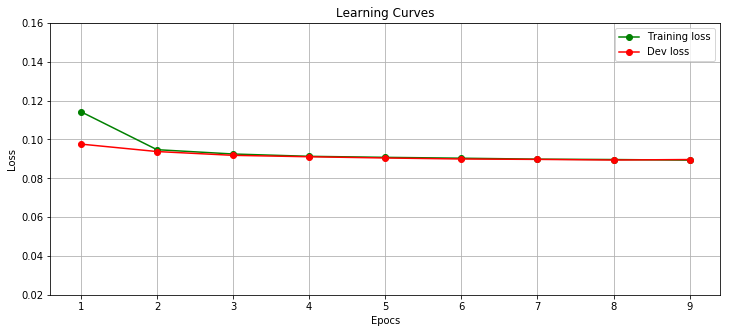

In [221]:
plt.figure(figsize=(12, 5))
plt.title("Learning Curves")
plt.ylim((0.02, 0.16))
plt.xlabel("Epocs")
plt.ylabel("Loss")
plt.grid()
epocs = [i+1 for i in range(len(metrics.losses))]
plt.plot(epocs, metrics.losses, 'o-', color="g", label="Training loss")
plt.plot(epocs, metrics.losses_dev, 'o-', color="r",label="Dev loss")
plt.legend(loc="best")

## Testing

In [131]:
import matplotlib.pyplot as plt

def plot_predictions(probabilities, title):
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(title)
    plt.autoscale(enable=False, axis='y')
    width = 0.85
    ind = np.arange(len(probabilities))
    plt.bar(ind, probabilities, width=width, color='g')
    plt.xticks(ind, labels)
    
def predict(text, model):
    plot_predictions(model.predict(sentences_to_indices(
        np.asarray([text.split()]),word_to_index, max_comment))[0], text)    

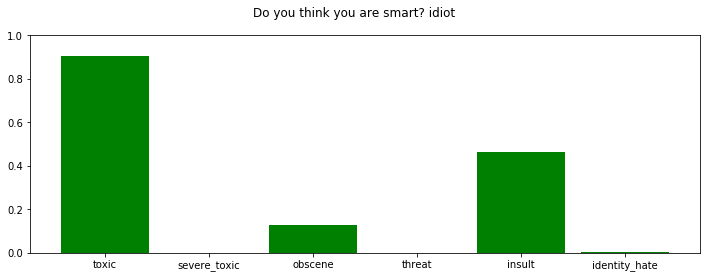

In [132]:
predict("Do you think you are smart? idiot", model_RNN)

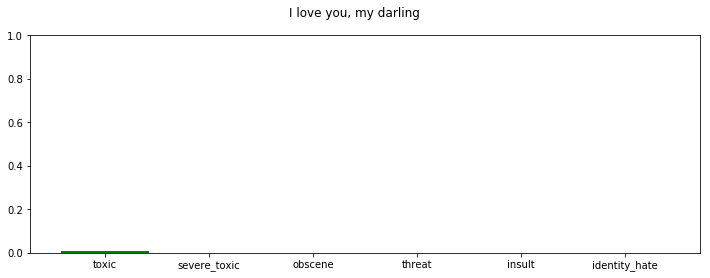

In [133]:
predict("I love you, my darling", model_RNN)

## Submission

In [134]:
y = model_RNN.predict(X_test_indices)
#y = model.predict(X_test_avg)

In [135]:
result = pd.concat([
    pd.DataFrame(id_test, columns=['id']), 
    pd.DataFrame(y, columns=labels)], axis=1)
result = result.set_index('id')
result = result.fillna(0.0)



result.to_csv('./result/anton_50epocs_2layers{}.csv'.format(datetime.now()), header=True)


